# Arbitrary state preparation using Model-Free Reinforcement Learning

This notebook showcases an application of the formalism introduced in PhysRevX.12.011059 (https://doi.org/10.1103/PhysRevX.12.011059) on arbitrary qubit state preparation, as depicted in the Appendix D.2b.

The implementation of the quantum environment is done here via Qiskit, using an Estimator primitive (https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/how-to-getting-started-with-estimator.html) for the execution of parametrized quantum circuits and Pauli expectation sampling.

Author of notebook: Arthur Strauss

Updated on 21/02/2024

In [1]:
import numpy as np
import os
import sys


from rl_qoc import QuantumEnvironment
from rl_qoc.helpers.tf_utils import select_optimizer, generate_model
from rl_qoc import QiskitConfig

# Qiskit imports for building RL environment (circuit level)

from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

In [2]:
from qiskit import QuantumRegister


# Ansatz function, could be at pulse level or circuit level


def apply_parametrized_circuit(qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    global n_actions
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], qreg[0])
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], qreg[1])
    qc.rzx(2 * np.pi * params[6], qreg[0], qreg[1])
    qc.u(2 * np.pi * params[7], 2 * np.pi * params[8], 2 * np.pi * params[9], qreg[1])
    qc.u(2 * np.pi * params[10], 2 * np.pi * params[11], 2 * np.pi * params[12], qreg[2])
    qc.rzx(2 * np.pi * params[13], qreg[1], qreg[2])

# Defining the QuantumEnvironment

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we can choose to go through the use of Qiskit Runtime, or to speed things up by using the local CPU and a state-vector simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

In [3]:
from gymnasium.spaces import Box

qubit_tgt_register = [0, 1, 2]  # Choose which qubits of the QPU you want to address
sampling_Paulis = 50
batchsize = (
    200  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
)
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector
n_actions = 14  # Choose how many control parameters in pulse/circuit parametrization
time_steps = 1  # Number of time steps within an episode (1 means you do one readout and assign right away the reward)
seed = 3590
estimator_options = {"seed_simulator": seed, "resilience_level": 0}
action_space = Box(low=-1, high=1, shape=(n_actions,), dtype=np.float32)
observation_space = Box(low=-1, high=1, shape=(2,), dtype=np.float32)

Choose below which IBM Backend to use. As we are dealing with circuit level implementation, we can look for a backend supporting Qiskit Runtime (could be a cloud simulator, or real backend) or simply set backend to None and rely on the Estimator primitive based on statevector simulation. In either case, we need access to one Estimator primitive to run the algorithm, as the feedback from the measurement outcomes is done by calculating Pauli expectation values.

In [4]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend,
where Qiskit Runtime is enabled
"""

backend_name = "ibm_perth"

# service = QiskitRuntimeService(channel='ibm_quantum')
# runtime_backend = service.get_backend(backend_name)
# estimator_options = {'resilience_level': 0}

In [5]:
"""
If using Qiskit native Estimator primitive
(statevector simulation)
"""

no_backend = None

In [6]:
backend = no_backend

In [7]:
# Define here target state density matrix

# Target state: GHZ state: (|000> + |111>)/sqrt(2)
ket0, ket1 = np.array([[1.0], [0]]), np.array([[0.0], [1.0]])
ket000, ket111 = np.kron(np.kron(ket0, ket0), ket0), np.kron(np.kron(ket1, ket1), ket1)
GHZ_state = (ket000 + ket111) / np.sqrt(2)
GHZ_dm = GHZ_state @ GHZ_state.conj().T
target_state = {"state": DensityMatrix(GHZ_dm), "physical_qubits": [0, 1, 2]}
# print("Target state Density matrix:", target_state)

In [8]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = QiskitConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
)

In [9]:
# Declare QuantumEnvironment variable
from rl_qoc import QEnvConfig, ExecutionConfig

# Define quantum environment
execution_config = ExecutionConfig(
    n_shots=N_shots,
    batch_size=batchsize,
    n_reps=1,
    sampling_paulis=sampling_Paulis,
    seed=seed,
    c_factor=1.0,
)
q_env_config = QEnvConfig(
    target=target_state,
    backend_config=Qiskit_setup,
    action_space=action_space,
    execution_config=execution_config,
)
q_env = QuantumEnvironment(training_config=q_env_config)
print(q_env.target)

StateTarget(DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j]],
              dims=(2, 2, 2)) on qubits [0, 1, 2])


We now define the Agent, which will be in general a Deep Neural Network.
We start by defining the hyperparameters of the training

In [10]:
# Hyperparameters for the agent
n_epochs = 1500  # Number of epochs
opti = "Adam"
eta = 0.01  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.2  # Parameter for clipping value (PPO)
grad_clip = 0.1
critic_loss_coeff = 0.5
optimizer = select_optimizer(
    lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2
)
sigma_eps = 1e-3  # for numerical stability

In [11]:
# Policy parameters: generate NN that will output mean and variances of the policy

# Policy parameters
N_in = observation_space.shape[
    -1
]  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [100, 100, 100]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros(
    (1, N_in)
)  # Here no feedback involved, so measurement sequence is always the same

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 100)          300         input_1[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 100)          10100       hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 100)          10100       hidden_1[0][0]                   
______________________________________________________________________________________________

In [12]:
# Plotting tools
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 10
%matplotlib inline

In [13]:
# Training loop

mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

policy_params_str = "Policy params:"

for i in tqdm(range(n_epochs)):

    Old_distrib = MultivariateNormalDiag(
        loc=mu_old, scale_diag=sigma_old, validate_args=True, allow_nan_stats=False
    )
    obs, _ = q_env.reset()
    with tf.GradientTape(persistent=True) as tape:

        mu, sigma, b = network(np.array([obs]), training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)
        q_env.mean_action = np.array(mu)
        q_env.std_action = np.array(sigma)
        Policy_distrib = MultivariateNormalDiag(
            loc=mu, scale_diag=sigma, validate_args=True, allow_nan_stats=False
        )

        action_vector = tf.stop_gradient(
            tf.clip_by_value(Policy_distrib.sample(batchsize), -1.0, 1.0)
        )

        _, reward, _, _, _ = q_env.step(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (
                tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-7
            )
            actor_loss = -tf.reduce_mean(
                tf.minimum(
                    advantage * ratio,
                    advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon),
                )
            )
        else:  # REINFORCE algorithm
            actor_loss = -tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage**2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)
    avg_return[i] = np.mean(q_env.reward_history, axis=1)[i]
    fidelities[i] = q_env.circuit_fidelity_history[i]
    print("Fidelity", fidelities[i])
    if i % visualization_steps == 0:
        clear_output(wait=True)  # for animation
        fig, ax = plt.subplots()
        ax.plot(
            np.arange(1, n_epochs, visualization_steps),
            avg_return[0:-1:visualization_steps],
            "-.",
            label="Avg return",
        )
        ax.plot(
            np.arange(1, n_epochs, visualization_steps),
            fidelities[0:-1:visualization_steps],
            label="State Fidelity",
        )
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()
        print("Maximum fidelity reached so far:", np.max(fidelities))

    # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
if isinstance(q_env.estimator, Estimator):
    q_env.estimator.session.close()

 99%|█████████▉| 1491/1500 [03:28<00:01,  6.29it/s]

Maximum fidelity reached so far: 0.9895733138093881

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.8953297224774188
Finished simulation benchmark
Sending Estimator job...


 99%|█████████▉| 1492/1500 [03:29<00:01,  6.67it/s]

Finished Estimator job
Reward (avg): 0.7958159914745991 Std: 0.05776927974827866
Fidelity 0.8953297224774188

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9038631037450204
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1493/1500 [03:29<00:00,  7.06it/s]

Finished Estimator job
Reward (avg): 0.776488728193309 Std: 0.060964404862232154
Fidelity 0.9038631037450204

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9038461511100855
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1494/1500 [03:29<00:00,  7.39it/s]

Finished Estimator job
Reward (avg): 0.7940625048805563 Std: 0.04872668221726673
Fidelity 0.9038461511100855

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9293656628819874
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1495/1500 [03:29<00:00,  7.61it/s]

Finished Estimator job
Reward (avg): 0.8347649048858103 Std: 0.04492832816704503
Fidelity 0.9293656628819874

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.914237747980376
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1496/1500 [03:29<00:00,  7.79it/s]

Finished Estimator job
Reward (avg): 0.7902068539008791 Std: 0.038649649321986515
Fidelity 0.914237747980376

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9441602540220488
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1497/1500 [03:29<00:00,  7.93it/s]

Finished Estimator job
Reward (avg): 0.8545139937997801 Std: 0.04010864920364603
Fidelity 0.9441602540220488

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9295853014458262
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1498/1500 [03:29<00:00,  8.02it/s]

Finished Estimator job
Reward (avg): 0.7737065538962389 Std: 0.032975606518051606
Fidelity 0.9295853014458262

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9226204193488432
Finished simulation benchmark
Sending Estimator job...


100%|█████████▉| 1499/1500 [03:29<00:00,  8.09it/s]

Finished Estimator job
Reward (avg): 0.8198378293074134 Std: 0.03929312230313244
Fidelity 0.9226204193488432

 Number of repetitions: 1
Starting simulation benchmark...
State fidelity: 0.9429877586075129
Finished simulation benchmark
Sending Estimator job...


100%|██████████| 1500/1500 [03:30<00:00,  7.14it/s]

Finished Estimator job
Reward (avg): 0.8210325179559125 Std: 0.032795111378010104
Fidelity 0.9429877586075129


In [14]:
print("Maximum fidelity reached:", np.max(fidelities), "at Epoch ", np.argmax(fidelities))

Maximum fidelity reached: 0.9895733138093881 at Epoch  533


Text(0, 0.5, 'Average return')

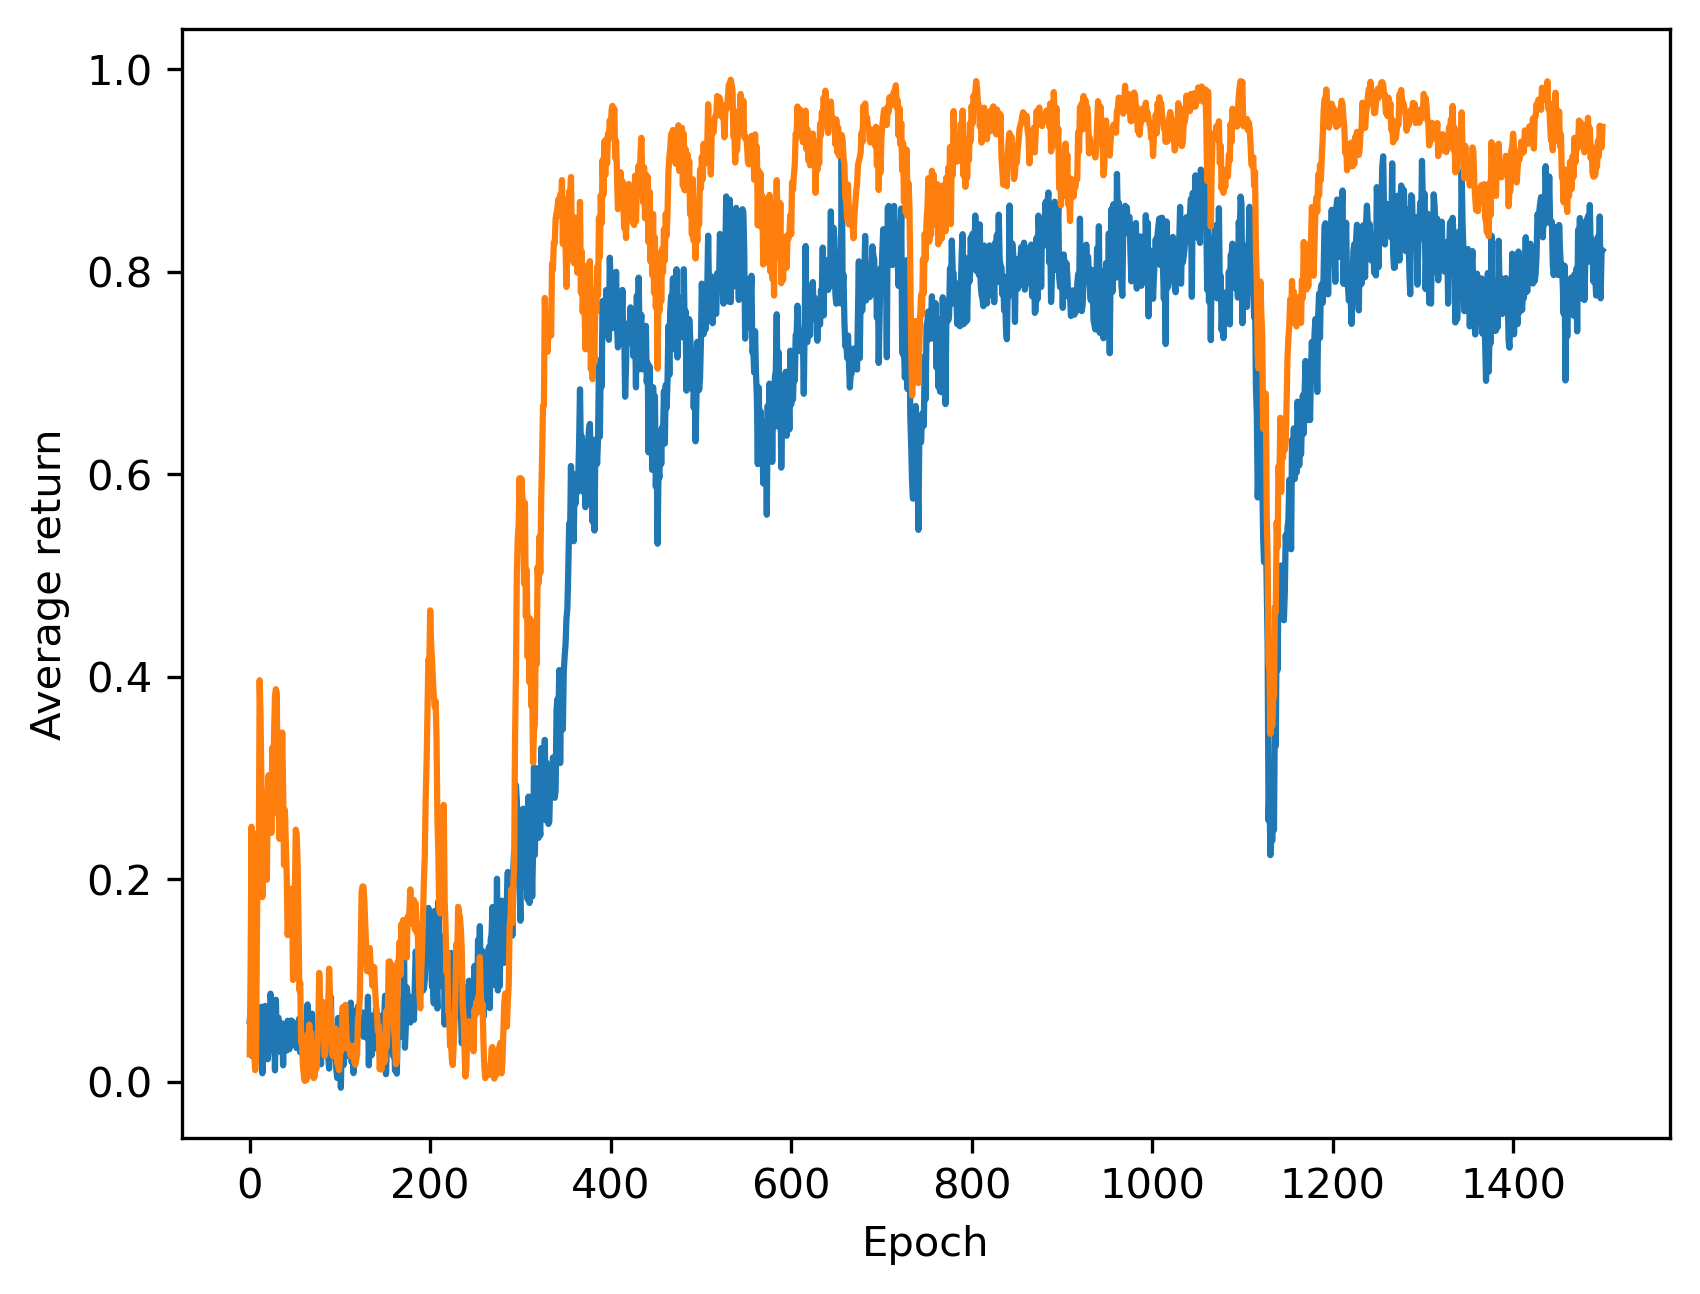

In [16]:
plt.plot(np.mean(q_env.reward_history, axis=1), label="Average return")
plt.plot(q_env.circuit_fidelity_history, label="State fidelity")
plt.xlabel("Epoch")
plt.ylabel("Average return")